# Machine Learning Dynamical Systems

In [ ]:
### Install dependencies
!pip install numpy matplotlib scipy
!pip install tqdm plotly
!pip install torch torchvision torchaudio
!pip install optuna
!pip install pytorch-lightning
!pip install google


In [1]:
#!/usr/bin/env python3
%matplotlib inline

# Basic import
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from sklearn.metrics import r2_score

# Pytorch import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, datasets
import torch.nn.functional as F

# Trainig with lighninig
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping 
from pytorch_lightning import Callback


# Import models
from models import LSTM,FFNet, ESN, Transformer
from auto_encoders import ConvAE, ConvVAE, VarFFAE
from Informer.model import InformerStack
#from pyESN import ESN


# Import plot functions
from plot import gen_trajectory, plot_trajectory, compare_trajectories, plot_3Dtrajectory

# Import dataset
from dataset import DynSysDataset

# Import callbacks
from callbacks import MetricsCallback

# Import functions for physical informed training
from utils import L63_field, EuDLoss, CeDLoss, Sampler, nKLDivLoss, R2Score

# Import progress bars
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep

# Optuna
import optuna
import plotly
from optuna.visualization import plot_parallel_coordinate, plot_param_importances, plot_contour


#Import sys
import sys

## Dataset generation

In [31]:
### Datasets
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

dt = 0.01
steps = 10000
seq_len = 500
feedforward_steps = 2
discard = 1000

# Include time in feature dimnesion
include_time = False

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

# Train dataset
state0 = [1.0, 1.0, 1.0]
train_states = DynSysDataset(state0, f, dt, steps, seq_len, discard, include_time=include_time)
t_train = train_states.time
train_dataset = train_states.dataset

# Validtion dataset
state0 = [2.0, 0.0, 3.0]
steps = 2000
val_states =  DynSysDataset(state0, f, dt, steps, seq_len, discard, include_time=include_time)
t_val = val_states.time
val_dataset = val_states.dataset

# Test dataset
state0 = train_dataset[-1][:3]
steps = 10000
test_states =  DynSysDataset(state0, f, dt, steps, seq_len, discard, include_time=include_time)
t_test = test_states.time
test_dataset = test_states.dataset

### Dataloader
batch_size = 20

train_dataloader = DataLoader(train_states, batch_size=batch_size, num_workers=0, shuffle=True)
val_dataloader = DataLoader(val_states, batch_size=batch_size,num_workers=0, shuffle=True)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


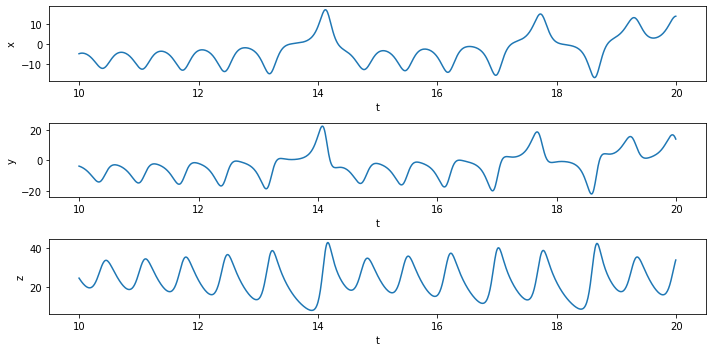

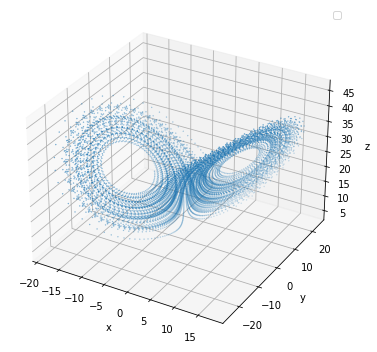

In [32]:
### Plot dataset

# Train
train_dynamics = plot_trajectory(train_dataset, time=t_train, labels=["x","y","z"], prediction_steps=1000)
train_attractor = plot_3Dtrajectory(train_dataset)

## Physical Informed dynamics

### LSTM

In [ ]:
### Hyperparameter optmization
#Check if the GPU is available


# Define annealing
max_num_epochs = 2000
initial_value = 5
exp_decay = np.exp(-np.log(initial_value) / max_num_epochs * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
annealing = [initial_value * (exp_decay ** i) for i in range(max_num_epochs)]
    
# Define loss function
loss_fn = PILoss(dt,field = L63_field(rho = 28.0, sigma = 10.0, beta = 8.0/3.0), annealing= [1]*max_num_epochs)

# Define objective function
def objective(trial):
    
    # Define objects to be optimized
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-1, log = True)
    hidden_units = trial.suggest_int("hidden_units", 10,200)
    layers_num = trial.suggest_int("layers_num", 2,5)
    drop_p = trial.suggest_float("dropout", 0.0, 1.0)
   
    # Define network
    input_size = 3
    model = LSTM(input_size, hidden_units, layers_num, drop_p)
    
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr)
        
    # Train
    max_num_epochs = 100
    early_stopping = False
    train_loss, val_loss = pi_train(model, device, train_dataloader, val_dataloader, loss_fn, optimizer, max_num_epochs, early_stopping)
    
    # Metric to be minimized is the last validation loss
    return np.mean(val_loss[-5:])


In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials= 20)
study.best_params  

In [ ]:
### Initialization
max_num_epochs = 2000

# Define loss function (physical informed)
loss_fn = EuDLoss(dt, field = L63_field(rho = 28.0,
                sigma = 10.0, beta = 8.0/3.0), include_time = include_time)
"""
c = 0.01
d = 0.5
sig_cv = [np.exp(-c*(i-max_num_epochs*d))/(1. + np.exp(-c*(i-max_num_epochs*d))) for i in range(max_num_epochs)]
plt.plot(sig_cv)
"""

# Define input size
input_size = 4 if include_time else 3

# Parameters
params = {
    "input_size" : input_size,
    "hidden_units" : 100,
    "layers_num" : 2,
    "drop_p" : 0.3,
    "loss_fn" : loss_fn,
    "lr" : 0.001,
    "feedforward_steps" : feedforward_steps,
    "curriculum_learning" : None,
}

# Define the callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 100, mode="min")

# Set seed and define network
torch.manual_seed(0)
net_pi = LSTM(params)

In [ ]:
### Set proper device and train
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

trainer = pl.Trainer(max_epochs=max_num_epochs, callbacks=[metrics_callback], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=net_pi, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)


In [ ]:
### Plot losses
plt.semilogy(metrics_callback.train_loss_log, label="Train loss")
plt.semilogy(metrics_callback.val_loss_log, label="Validation loss")
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/loss_lstm.png")

In [ ]:
### Generate a trajectory with network
prediction_steps = 4000
net_states = gen_trajectory(net_pi.cpu(), test_dataset[0],prediction_steps)
compare_trajectories(net_states, t_test, filename="images/lstm_lorenz63_tf_short", labels=["x", "y", "z"], prediction_steps=prediction_steps)


In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net_pi.state_dict(),
            "parameters" : params}
# Save the state dict to a file
torch.save(net_dict,"trained_models/LSTM_CL(seq=500,ffstep=2)")


### Autograd time differantiation

In [ ]:
# Train dataset
state0 = [1.0, 1.0, 1.0]
include_time = True
train_states = DynSysDataset(state0, f, dt, steps, seq_len, discard, include_time=include_time)
t_train = train_states.time
train_dataset = train_states.dataset
train_dataloader = DataLoader(train_states, batch_size=batch_size, num_workers=0, shuffle=True)

In [ ]:
# Define network
max_num_epochs = 2000
c = 0.01
d = 0.5

loss_fn = EuDLoss(dt, field = L63_field(rho = 28.0,
                sigma = 10.0, beta = 8.0/3.0), include_time=include_time)

input_size = 4 if include_time else 3
params = {
    "input_size" : 4,
    "hidden_units" : 100,
    "layers_num" : 2,
    "drop_p" : 0.3,
    "loss_fn" : loss_fn,
    "lr" : 0.01,
    "feedforward_steps" : 1,
    "curriculum_learning" : None,
}

# Define the callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 100, mode="min")

# Set seed and define network
torch.manual_seed(0)
net_pi = LSTM(params)

In [ ]:
### Trye torch.autograd
batch = next(iter(train_dataloader))
net_pi.set_output(False)
out = net_pi(batch)
# Reshape
batch = torch.reshape(batch[0,:100], (100,4))
out = torch.reshape(out[0,:100], (100,4))

grad_outputs = torch.tensor([[0.,0.,0.,1.]]*100)
print(grad_outputs.shape)

grad = torch.autograd.grad(out[0], batch[0], grad_outputs=grad_outputs[0], is_grads_batched=False)
print(grad)


### Transformer

In [ ]:
max_num_epochs = 1000

loss_fn = EuDLoss(dt, field = L63_field(rho = 28.0,
                sigma = 10.0, beta = 8.0/3.0))
params_tf = {
    "d_model" : 3,
    "nhead" : 3,
    "num_encoder_layers" : 6,
    "num_decoder_layers" : 6,
    "dim_feedforward" :  360,
    "dropout" : 0.3,
    "activation" : "relu",
    "lr" : 0.01,
    "loss_fn" : loss_fn,
    "apply_tgt_mask" : True,
    "apply_src_mask" : False,
}

# Define the callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 100, mode="min")

# Set seed and network
torch.manual_seed(0)
net_tf = Transformer(params_tf)

In [ ]:
### Trainig
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

trainer = pl.Trainer(max_epochs=max_num_epochs, callbacks=[metrics_callback], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=net_tf, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

In [ ]:
### Plot losses
plt.semilogy(metrics_callback.train_loss_log, label="Train loss")
plt.semilogy(metrics_callback.val_loss_log, label="Validation loss")
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/loss_transformer.png")

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net_pi.state_dict(),
            "parameters" : params}
# Save the state dict to a file
torch.save(net_dict,"trained_models/Transformer")


### Informer


In [ ]:
# Define loss functions
loss_fn = EuDLoss(dt, field = L63_field(rho = 28.0, sigma = 10.0, beta = 8.0/3.0))

# Define the network
torch.manual_seed(0)
net_inf = InformerStack(enc_in = 3, dec_in = 3, c_out = 3, seq_len = 499, label_len = 499, out_len = 1, 
                factor=5, d_model=512, n_heads=8, e_layers=[3,2,1], d_layers=2, d_ff=512, 
                dropout=0.3, lr=0.001, loss_fn=loss_fn, attn='prob', embed='fixed', freq='h', activation='gelu')

# Define the callbacks
metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 100, mode="min")

In [ ]:
### Set proper device and train
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

trainer = pl.Trainer(max_epochs=100, callbacks=[metrics_callback], accelerator="auto", log_every_n_steps=1)
trainer.fit(model=net_inf, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)



In [ ]:
### Plot losses
plt.semilogy(metrics_callback.train_loss_log, label="Train loss")
plt.semilogy(metrics_callback.val_loss_log, label="Validation loss")
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/loss_informer.png")

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net_pi.state_dict(),
            "parameters" : params}
# Save the state dict to a file
torch.save(net_dict,"trained_models/Informer")

### Convolutional Autoencoder

### Convolutional Variational Auto-Encoder

In [57]:
# Define loss function
loss_fn = nn.MSELoss() 

# Define network
params = {
    "in_channels" : (1,16),
    "out_channels" : (16,32),
    "kernel_sizes" : ((100,3), (100,1)),
    "padding" : (0, 0),
    "encoded_space_dim" : 1,
    "act" : nn.ReLU,
    "drop_p" : 0.3,
    "seq_len" : seq_len,
    "sampler" : Sampler(),
    "loss_fn" : loss_fn,
    "lr" : 0.001,
    "beta" : 0.00001,
}

torch.manual_seed(0)
net_ae = ConvVAE(params)



# Dataloaders
batch_size = 20

train_states = DynSysDataset(state0, f, dt, steps, seq_len, discard, include_time=include_time)
val_states =  DynSysDataset(state0, f, dt, steps, seq_len, discard, include_time=include_time)
test_states =  DynSysDataset(state0, f, dt, steps, seq_len, discard, include_time=include_time)
# Unsqueeze
train_states.data = train_states.data.unsqueeze(1)
val_states.data = val_states.data.unsqueeze(1)
test_states.data = test_states.data.unsqueeze(1)

train_dataloader = DataLoader(train_states, batch_size=batch_size, num_workers=0, shuffle=True)
val_dataloader = DataLoader(val_states, batch_size=batch_size, num_workers=0, shuffle=True)
test_dataloader = DataLoader(test_states, batch_size=batch_size, num_workers=0, shuffle=True)

batch = next(iter(train_dataloader))
print(batch.shape)
rec, mean, logvar = net_ae(batch)
print(rec.shape)

metrics_callback =  MetricsCallback()
early_stopping = EarlyStopping(monitor="val_loss", patience = 1000, mode="min")

torch.Size([20, 1, 500, 3])
torch.Size([20, 1, 500, 3])


In [64]:
trainer = pl.Trainer(max_epochs=2000, callbacks=[metrics_callback])
trainer.fit(model=net_ae, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type         | Params
-----------------------------------------
0 | encoder | VConvEncoder | 5.0 M 
1 | decoder | ConvDecoder  | 2.5 M 
2 | sampler | Sampler      | 0     
3 | loss_fn | MSELoss      | 0     
-----------------------------------------
7.5 M     Trainable params
0         Non-trainable params
7.5 M     Total params
30.188    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:727: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


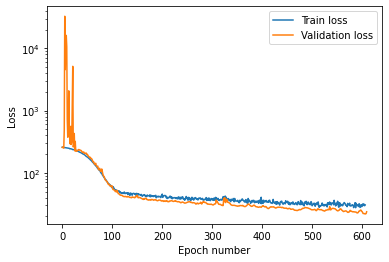

In [65]:
### Plot losses
plt.semilogy(metrics_callback.train_loss_log, label="Train loss")
plt.semilogy(metrics_callback.val_loss_log, label="Validation loss")
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/loss_autoencoder.png")

torch.Size([20, 1, 500, 3])


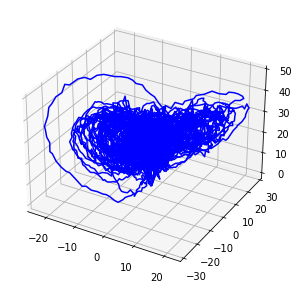

In [66]:
#perturbation = torch.tensor([0.01]*len(train_dataset), dtype=torch.float32).unsqueeze(1).unsqueeze(0)
print(val_states.data.shape)
rec, mean, log_var = net_ae(val_states.data)
rec = rec.detach().numpy()
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection="3d")
for i in range(len(rec)):
    ax.plot(rec[i,0,:,0], rec[i,0,:,1], rec[i,0,:,2], c="b")

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net_pi.state_dict(),
            "parameters" : params}
# Save the state dict to a file
torch.save(net_dict,"LSTM_CL")


### Reservoir Networks

In [ ]:
net_esn = ESN(n_inputs = 3, n_outputs = 3, n_reservoir = 250, spectral_radius = 1.2, noise = 0.05, extended_states=True)

In [ ]:
# Varun Reservoir network
pred, training_rmse, transient = net_esn.fit(train_dataset[:-1,:], train_dataset[1:,:])

net_states = net_esn.predict(40,test_dataset)



In [ ]:
# My reservoir network
params = {
    "input_dimension" : 3,
    "hidden_dimension" : 500,
    "out_dimension" : 3,
    "beta" : 100000,
    "spectral_radius" : 1.2,
    "edges" : 6*500
}
net_esn = ESN(params)


In [ ]:
net_esn.fit(train_dataset)
print(net_esn.P)

In [ ]:
net_states = net_esn.predict(test_dataset, continuation=True)

In [ ]:
net_states = np.array(net_states)


fig, axs = plt.subplots(figsize=(10,5), ncols=2, nrows=3)
gs = axs[1, 1].get_gridspec()

index = 0
for ax in axs[0:,0]:
    ax.set_xlabel("t")
    ax.plot(t_test,net_states[:, index], label="Predicted")
    ax.plot(t_test,test_dataset[:, index], label="Actual")
    ax.legend(loc = "upper right", fontsize = "x-small")
    index += 1
    
axs[0,0].set_ylabel("x")
axs[1,0].set_ylabel("y")
axs[2,0].set_ylabel("z")

# remove the underlying axes
for ax in axs[0:, -1]:
    ax.remove()
    
axbig = fig.add_subplot(gs[0:, -1], projection="3d")
axbig.set_title("Predicted Lorenz attractor")
axbig.plot(net_states[:,0], net_states[:,1], net_states[:,2])
axbig.legend()


fig.tight_layout()
plt.savefig("resnet_lorenz63")
plt.show()

## Lyapunov exponents prediction

In [ ]:
### Classic computation

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01 # Dynamics timestep
n_time = 10 # How much larger than dt is tau
tau = n_time*dt # 


def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def J(state, t):
    """
    Compute the jacobian at a given state of the trajectory
    """
    x, y, z = state # Unpack the state vector
    jac = np.zeros((3,3)) # Initialize the jacobian
    # Compute derivatives
    jac[0][0] =  -sigma
    jac[0][1] = sigma
    jac[1][0] = rho - z
    jac[1][1] = -1.
    jac[1][2] = -x
    jac[2][0] = y
    jac[2][1] = x
    jac[2][2] = -beta
    
    return jac

# Define derivative function
def df(M, t, J):
    return np.dot(J,M)


# Train dataset (discard first 100 steps) --- Odeint
state0 = [1.0, 1.0, 1.0]
dt = 0.01
train_steps = 4000
t_train = np.arange(0.0, (1000+train_steps)*dt, dt)
train_dataset = odeint(f, state0, t_train)[1000:]
t_train = t_train[1000:]

# Network generated dataset
#net_states = gen_trajectory(net_pi.cpu(), test_dataset[0], prediction_steps = 11000)[1000:]

# Compute 
from odeintw import odeintw
j = 10
M0 = np.eye(3)
time = np.arange((j-1)*tau, j*tau, dt)
Jac = J(train_dataset[(j-1)*n_time], (j-1)*tau) 
M = odeintw(df, M0, time, args=(Jac,))[-1]
print(M)

In [ ]:
# Initialize perturbation matrix and Local Lyapunov Exponents list
from scipy.linalg import qr
import math
Q = np.eye(3) # choose identity
LLEs = []
n_time = 1

# Loop over dataet, jump every n_time steps
for j in range(len(test_dataset)):
    # Propagate perturbation
    M = np.eye(3)
    time = np.arange(j*dt, (j+n_time)*dt, dt)
    Jac = J(test_dataset[j], j*dt) 
    M = odeintw(df, M, time, args=(Jac,))[-1]
    # Propagate perturbation
    V = np.matmul(M,Q)
    # QR decomposition
    Q, R = qr(V, check_finite=True)
    # Compute local lyapunov exponents
    lles = np.log(np.diag(R))/dt
    # Append
    LLEs.append(lles)
    
        
LLEs = np.array(LLEs)

In [ ]:

lle_fig = plot_trajectory(LLEs, time=t_train, prediction_steps=2000, labels=["LLE1", "LLE2", "LLE3"])
lle1_attractor = plot_3Dtrajectory(test_dataset, color=LLEs[:,0])
lle2_attractor = plot_3Dtrajectory(test_dataset, color=LLEs[:,1])
lle3_attractor = plot_3Dtrajectory(test_dataset, color=LLEs[:,2])

In [ ]:
### Dataset generation

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

eps = 0.01 # Perturbation
len_seq = 5 # Length of the pertubed sequence
t = np.arange(0.0, dt*len_seq, dt) # Time array

# Add pertubation dimension and dynamics dimension
print(states_dataset.shape) 
pd = np.expand_dims(states_dataset, axis=1)
pd = np.expand_dims(pd, axis=1)
perturbed_dataset = np.concatenate((pd, pd), axis=2)
perturbed_dataset = np.concatenate((perturbed_dataset, pd), axis=2)
print(perturbed_dataset.shape)


# Add perturbation
for i in range(3):
    perturbed_dataset[:,:,i,i] += eps
    
print(perturbed_dataset[0,:,0,:])

le_dataset = []
# Run the dynamics for all perturbations for len_seq steps
for state in perturbed_dataset:
    ev_dyn0 = np.expand_dims(odeint(f, state[0,0,:], t), axis=1)
    ev_dyn1 = np.expand_dims(odeint(f, state[0,1,:], t), axis=1)
    ev_dyn2 = np.expand_dims(odeint(f, state[0,2,:], t), axis=1)
   
    ev_dyn = np.concatenate((ev_dyn0, ev_dyn1), axis=1)
    ev_dyn = np.concatenate((ev_dyn, ev_dyn2), axis=1)
    le_dataset.append(ev_dyn)

# Convert to numpy
le_dataset = np.array(le_dataset)

In [ ]:
### Convert to tensor
l_seq = 20
num_sequences = int(4000/l_seq)

le_dataset = torch.tensor(le_dataset, requires_grad=True,dtype=torch.float)


### Dataloader
le_dataloader = DataLoader(le_dataset, batch_size=16, shuffle=True)
print(next(iter(le_dataloader)).shape)

### Training

In [ ]:
# Define network
input_size = 3
hidden_units = 10
layers_num = 2
drop_p = 0.3
net_le = LSTM(input_size, hidden_units, layers_num, drop_p)

In [ ]:
#Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Move network to the proper device
net_pi.to(device)
# Network in training mode (enable stochastic layers, e.g. dropout)
net_pi.train()



# Create pbar 
pbar = tqdm(range(num_epochs))

for epoch_num in pbar:
    epoch_losses = []
    
    i = 0
    for batch_sample in le_dataloader:
        
        ### Move samples to the proper device
        batch_sample = batch_sample.to(device)

        ### Prepare network input and labels
        net_input  = batch_sample[:, :-1, :]
        labels = batch_sample[:, 1:, :]

        ### Forward pass
        # Clear previous recorded gradients
        optimizer.zero_grad()
        # Forward pass
        net_out, _ = net_pi(net_input) # we do not need the rnn state at this point, we can ignore the output with "_"
    
        ### Update network
        # Evaluate data driven loss
        dd_loss = loss_fn(net_out, labels)
        # Evaluate physical informed loss
        pi_loss = piloss_fn(net_input,net_out)
        
        loss = beta[i]*dd_loss + pi_loss
    
        # Backward pass
        loss.backward()
        # Update
        optimizer.step()
        # Save batch loss
        epoch_losses.append(loss.data.cpu().numpy())
        
        # Update counter
        i = i+1
        
  
    # Compute epoch loss
    epoch_loss = np.mean(epoch_losses)
    
    # Set description
    pbar.set_description("Train loss: %s" %round(np.mean(epoch_losses),3))
    
    # Append
    log_loss.append(epoch_loss)


# Now output in function of the time and initial condition